<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/main/emo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [84]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense, Embedding, Flatten
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.optimizers import Adam, RMSprop
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import math
import keras.backend as K

In [12]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/emotion/data/preprocessed.csv'
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
seed = 123456
num_words = 10000
max_len = 250

In [13]:
data = read_data(data_path,['text', 'emotions'])
data.columns = cols
data.sample(5)

,text,target
26295,i feel like i keep things pretty do,joy
34351,i feel i should have abused his caring nature ...,sadness
8273,i acted in the moment feeling that that studen...,sadness
40833,i feel a little bit lucky,joy
2452,i start to feel lively again and do not want t...,joy


In [15]:
data.shape

(50000, 2)

In [18]:
data['target'].unique()

array(['joy', 'fear', 'sadness', 'anger', 'love', 'surprise'],
      dtype=object)

In [20]:
data = data[~data['target'].isin(['love'])]

In [21]:
data['target'].unique()

array(['joy', 'fear', 'sadness', 'anger', 'surprise'], dtype=object)

In [24]:
data.groupby('target').count().reset_index()

,target,text
0,anger,6923
1,fear,5635
2,joy,16982
3,sadness,14553
4,surprise,1744


In [22]:
train, test = train_test_split(data, test_size=0.35, \
                             random_state=seed, stratify=data['target'])
val, test = train_test_split(test, test_size=0.5, \
                             random_state=seed, stratify=test['target'])

In [23]:
train.shape, val.shape, test.shape

((29794, 2), (8021, 2), (8022, 2))

In [29]:
print(val['target'].unique(), \
      train['target'].unique(), \
      test['target'].unique())

['fear' 'joy' 'anger' 'sadness' 'surprise'] ['fear' 'sadness' 'anger' 'joy' 'surprise'] ['anger' 'sadness' 'joy' 'surprise' 'fear']


In [26]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [102]:
train_x = get_sequences(tokenizer, max_len, train['text'])
val_x = get_sequences(tokenizer, max_len, val['text'])
test_x = get_sequences(tokenizer, max_len, test['text'])

In [ ]:
strategy = {"anger":16000, "fear":16000, "surprise":16000, "sadness": 16000, "joy": 16000}
oversample = SMOTE(sampling_strategy=strategy)
train_x, train_y = oversample.fit_resample(train_x,\
                                            train['target'])

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (16000) in class anger will be larger than the number of samples in the majority class (class #joy -> 11038)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (16000) in class fear will be larger than the number of samples in the majority class (class #joy -> 11038)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (16000) in class surprise will be larger than the number of samples in the majority class (class #joy -> 11038)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (16000) in class sadness will be larger than the number of samples in the majority

In [ ]:
counter = Counter(train_y)
for k,v in counter.items():
	per = v / len(train_y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [37]:
train_y = OH_fit_transform(pd.Series(train_y))
val_y = OH_transform(val['target'])
test_y = OH_transform(test['target'])

In [86]:
def step_decay(epoch):
	initial_lrate = 5e-5
	drop = 0.5
	epochs_drop = 3
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [93]:
def build_mlp():
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(Embedding(num_words, 128))
    model.add(Flatten())
    model.add(Dense(5, activation='softmax'))
    return model

In [94]:
K.clear_session()
mlp_model = build_mlp()
mlp_model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 128)          1280000   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 160005    
Total params: 1,440,005
Trainable params: 1,440,005
Non-trainable params: 0
_________________________________________________________________


In [95]:
file_path = 'emb_simple.h5'
mlp_cb = [
          EarlyStopping(monitor='val_accuracy', patience=5, mode='max', \
                        restore_best_weights=True),
          ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, \
                          save_best_only=True,  mode='max'),
          LearningRateScheduler(step_decay)
          ]

In [96]:
history_mlp = mlp_model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    epochs = 100,
    batch_size=64,
    callbacks=mlp_cb
)

Epoch 1/100
1071/1071 [==============================] - 36s 33ms/step - loss: 1.5859 - accuracy: 0.2391 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7292 - val_accuracy: 0.0987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.09874, saving model to emb_simple.h5
Epoch 2/100
1071/1071 [==============================] - 34s 32ms/step - loss: 1.5486 - accuracy: 0.2689 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6737 - val_accuracy: 0.1787 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_accuracy improved from 0.09874 to 0.17866, saving model to emb_simple.h5
Epoch 3/100
1071/1071 [==============================] - 35s 33ms/step - loss: 1.4817 - accuracy: 0.3226 - precision: 0.0632 - recall: 1.0394e-05 - val_loss: 1.6218 - val_accuracy: 0.2666 - val_precision: 0.2857 - val_recall: 4.9869e-04

Epoch 00003: val_accuracy improved from 0.17866 to 0.26655, saving model to emb_simple.h5
Epo

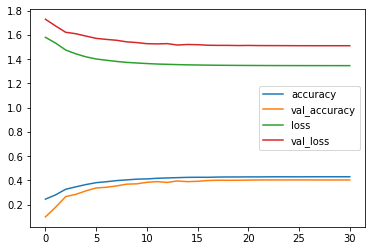

In [97]:
pd.DataFrame(history_mlp.history)[metr].plot()

 12/126 [=>............................] - ETA: 0s 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


126/126 [==============================] - 1s 5ms/step
Accuracy:	41.0%


              precision    recall  f1-score   support

           0       0.26      0.33      0.29      1212
           1       0.23      0.30      0.26       986
           2       0.54      0.59      0.56      2972
           3       0.59      0.31      0.41      2547
           4       0.07      0.15      0.10       305

    accuracy                           0.41      8022
   macro avg       0.34      0.34      0.33      8022
weighted avg       0.46      0.41      0.42      8022



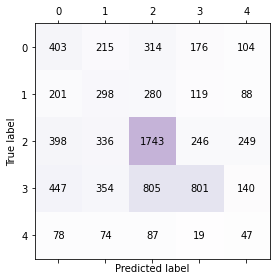

In [99]:
model_evaluate(mlp_model, test_x, test_y, 64)

In [101]:
mlp_model.predict(get_sequences(tokenizer,max_len,['I feel too good to see you']))

array([[0.2258618 , 0.24411301, 0.2090826 , 0.20687103, 0.11407156]],
      dtype=float32)